In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import sys,os

from core.data import load_records

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ASTROMER input format

In [3]:
dataset, val_data = load_records('./data/records/ogle/train', 128, val_data=20, no_shuffle=False,
                              msk_frac=0.5, rnd_frac=0.2, same_frac=0.2,
                              max_obs=100)

(200, 1)


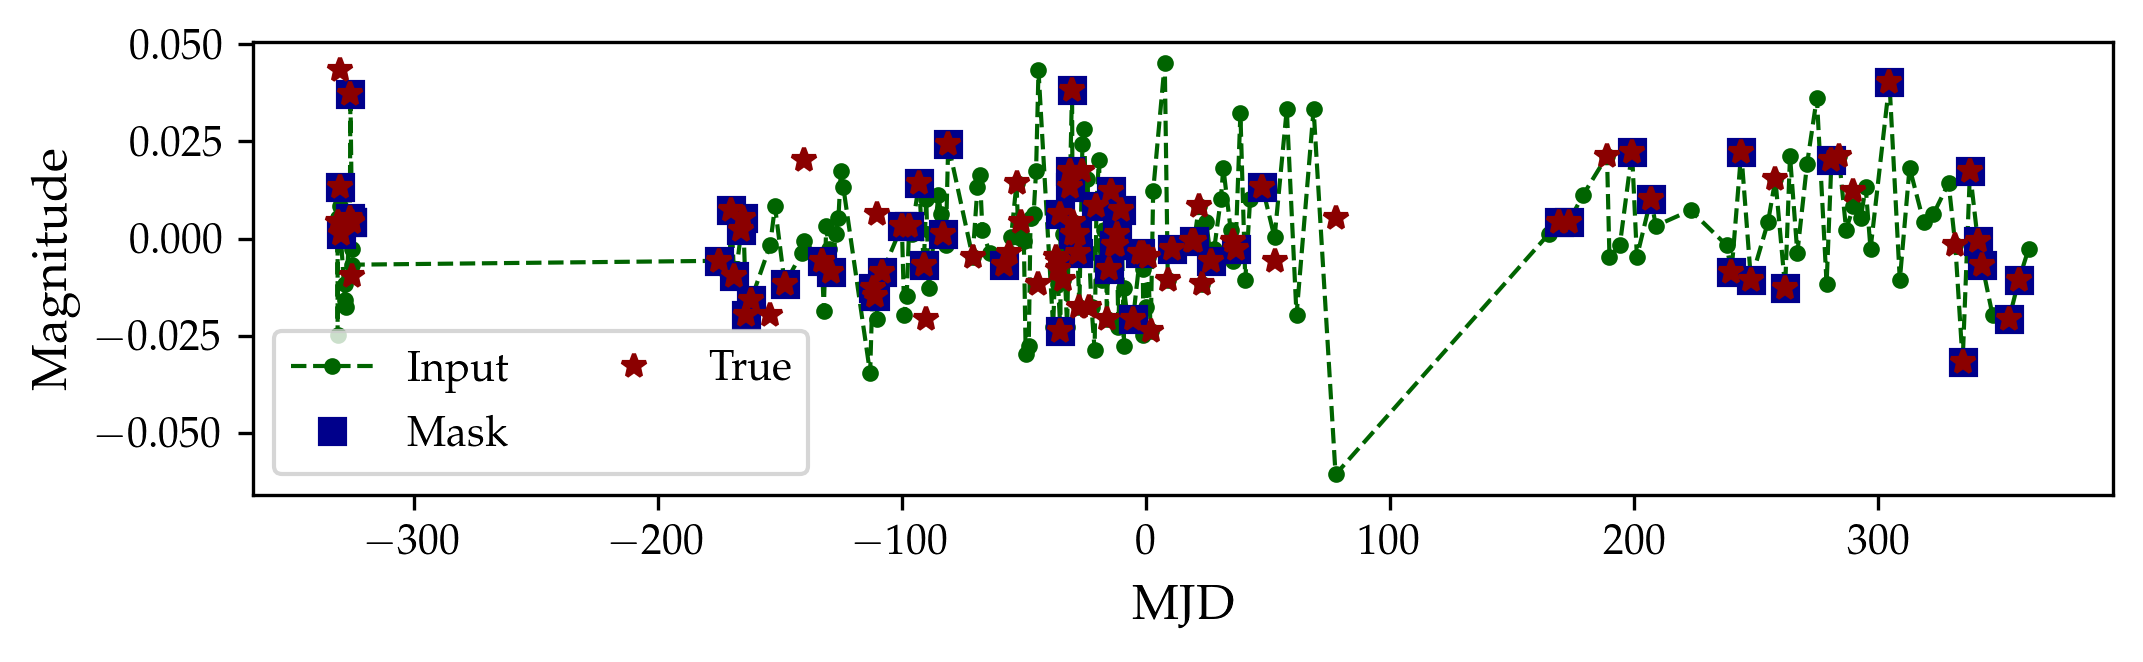

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(8,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
for batch in dataset:

    x_input  = batch['input'][-1]
    x_output = batch['output'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])
    mask_out = tf.squeeze(batch['mask_out'][-1])
    

    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)
    

    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)
        
    axes.plot(t_sample, x_output, color='darkgreen', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=2, fontsize=10)#bbox_to_anchor=(0.1, 1.2), ncol=4)
    break
# fig.savefig('presentation/figures/input.png', transparent=True)
fig.savefig('presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

In [5]:
# fig.savefig('./presentation/figures/input.pdf', bbox_inches='tight', format='pdf')

# Classification input 

In [49]:
dataset = load_records('./data/records/alcock/test', 1000, val_data=0., no_shuffle=True,
                              msk_frac=0., rnd_frac=0., same_frac=0.,
                              max_obs=200)

No validation


In [50]:
for d in dataset:    
    print(np.unique(d['label']))

[0 1 2 3 4 5]


In [51]:
df_labels = pd.read_csv('./data/records/alcock/test_objs.csv')
df_labels['class'].unique()

array(['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc'], dtype=object)

In [52]:
df_labels = pd.read_csv('./data/records/alcock/train_objs.csv')
class_names = np.unique(df_labels['class'].values)
class_names = [x.replace('_', '\_') for x in class_names]

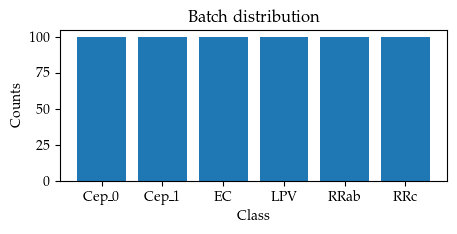

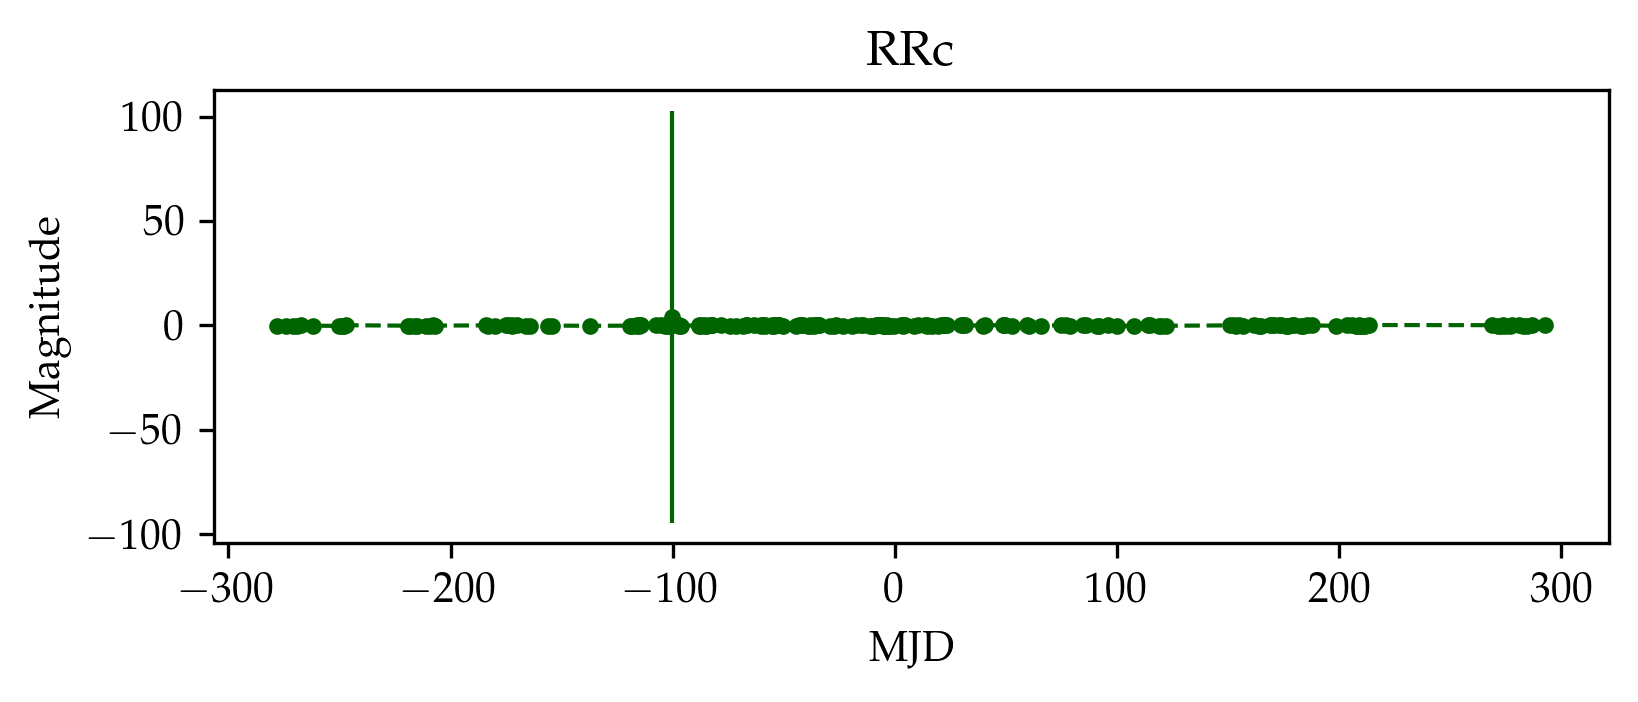

In [72]:
for batch in dataset:

    index = np.random.randint(0, batch['label'].shape)[0]
    e_sample = batch['obserr'][index]
    y_label  = batch['label'][index]
    x_input  = batch['input'][index]
    t_sample = batch['times'][index]
    
    mask_in  = 1.-tf.squeeze(batch['mask_in'][index])
    mask_out = 1.-tf.squeeze(batch['mask_out'][index])

    times_masked = tf.boolean_mask(t_sample, mask_in)[:, 0]
    serie_masked = tf.boolean_mask(x_input, mask_in)[:, 0]
    erros_masked = tf.boolean_mask(e_sample, mask_in)[:, 0]

    # BATCH DISTRIBUTION
    plt.figure(figsize=(5,2), dpi=100)
    batch_labels = batch['label'].numpy()
    uniques, counts = np.unique(batch_labels, return_counts=True)
    x = range(len(uniques))
    plt.bar(x, counts)
    plt.xticks(x, class_names[:len(uniques)])
    plt.title('Batch distribution')
    plt.xlabel('Class')
    plt.ylabel('Counts')
    plt.show()
    
    # Lightcurve
    fig, axes = plt.subplots(1, 1, figsize=(6,2), sharex=True, sharey=True, 
                             gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, dpi=300)
    axes.errorbar(times_masked, serie_masked, yerr=erros_masked, 
                  color='darkgreen', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.set_title('{}'.format(str(class_names[y_label])))
    axes.set_xlabel('MJD')
    axes.set_ylabel('Magnitude')   
    fig.savefig('presentation/figures/raw_input.png', transparent=True)
    plt.show()
    break